## Fu: calculate velocities

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import scvelo as scv

In [19]:
import warnings
warnings.filterwarnings("ignore")

### read in data

cellranger/velocyto files

In [3]:
# adata files from cellranger
cellranger = sc.read_h5ad("../data/fu_cellranger.h5ad")

In [4]:
# loom files from velocyto
ldata1 = scv.read('../velocyto/MJ001.loom', cache=True)
ldata2 = scv.read('../velocyto/MJ002.loom', cache=True) 
ldata3 = scv.read('../velocyto/MJ003.loom', cache=True) 
ldata5 = scv.read('../velocyto/MJ005.loom', cache=True)
ldata6 = scv.read('../velocyto/MJ006.loom', cache=True)
ldata7 = scv.read('../velocyto/MJ007.loom', cache=True) 
ldata8 = scv.read('../velocyto/MJ008.loom', cache=True) 
ldata9 = scv.read('../velocyto/MJ009.loom', cache=True) 
ldata16 = scv.read('../velocyto/MJ016.loom', cache=True) 
ldata17 = scv.read('../velocyto/MJ017.loom', cache=True) 
ldata18 = scv.read('../velocyto/MJ018.loom', cache=True) 
ldata19 = scv.read('../velocyto/MJ019.loom', cache=True)

In [5]:
# rename barcodes
ldata1.obs_names = ldata1.obs_names.str.replace("x", "-1_1").str.replace("MJ001:", "")
ldata2.obs_names = ldata2.obs_names.str.replace("x", "-1_2").str.replace("MJ002:", "")
ldata3.obs_names = ldata3.obs_names.str.replace("x", "-1_3").str.replace("MJ003:", "")
ldata5.obs_names = ldata5.obs_names.str.replace("x", "-1_4").str.replace("MJ005:", "")
ldata6.obs_names = ldata6.obs_names.str.replace("x", "-1_5").str.replace("MJ006:", "")
ldata7.obs_names = ldata7.obs_names.str.replace("x", "-1_12").str.replace("MJ007:", "")
ldata8.obs_names = ldata8.obs_names.str.replace("x", "-1_6").str.replace("MJ008:", "")
ldata9.obs_names = ldata9.obs_names.str.replace("x", "-1_7").str.replace("MJ009:", "")
ldata16.obs_names = ldata16.obs_names.str.replace("x", "-1_8").str.replace("MJ016:", "")
ldata17.obs_names = ldata17.obs_names.str.replace("x", "-1_9").str.replace("MJ017:", "")
ldata18.obs_names = ldata18.obs_names.str.replace("x", "-1_10").str.replace("MJ018:", "")
ldata19.obs_names = ldata19.obs_names.str.replace("x", "-1_11").str.replace("MJ019:", "")

In [6]:
# merge adata with loom file generated by velocyto
adata1 = scv.utils.merge(cellranger[cellranger.obs['id'] == 'MJ001'], ldata1)
adata2 = scv.utils.merge(cellranger[cellranger.obs['id'] == 'MJ002'], ldata2)
adata3 = scv.utils.merge(cellranger[cellranger.obs['id'] == 'MJ003'], ldata3)
adata5 = scv.utils.merge(cellranger[cellranger.obs['id'] == 'MJ005'], ldata5)
adata6 = scv.utils.merge(cellranger[cellranger.obs['id'] == 'MJ006'], ldata6)
adata7 = scv.utils.merge(cellranger[cellranger.obs['id'] == 'MJ007'], ldata7)
adata8 = scv.utils.merge(cellranger[cellranger.obs['id'] == 'MJ008'], ldata8)
adata9 = scv.utils.merge(cellranger[cellranger.obs['id'] == 'MJ009'], ldata9)
adata16 = scv.utils.merge(cellranger[cellranger.obs['id'] == 'MJ016'], ldata16)
adata17 = scv.utils.merge(cellranger[cellranger.obs['id'] == 'MJ017'], ldata17)
adata18 = scv.utils.merge(cellranger[cellranger.obs['id'] == 'MJ018'], ldata18)
adata19 = scv.utils.merge(cellranger[cellranger.obs['id'] == 'MJ019'], ldata19)

In [20]:
# concatenate samples
velocyto = adata1.concatenate(adata2, adata3, adata5, adata6, adata7, adata8, adata9, adata16, adata17, adata18, adata19, index_unique=None)

In [ ]:
# save
velocyto.write_h5ad(filename="../data/fu_velocyto.h5ad")

alevin-fry file

In [8]:
alevin = sc.read_h5ad("../data/fu_salmon.h5ad")

### compute velocities

In [9]:
# preprocessing
scv.pp.filter_genes(velocyto)
scv.pp.normalize_per_cell(velocyto)

scv.pp.filter_genes(alevin)
scv.pp.normalize_per_cell(alevin)

# ensure that highly variable genes are the same
assert (velocyto.var["highly_variable"].sort_index()).equals(alevin.var["highly_variable"].sort_index()), "computing velocities on different genes"

Normalized count data: spliced, unspliced.
Normalized count data: spliced, unspliced.


In [10]:
# compute neighborhood graph and moments for velocity estimation
scv.pp.moments(velocyto)
scv.pp.moments(alevin)

computing neighbors
    finished (0:00:32) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:31) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing neighbors
    finished (0:00:09) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:36) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [11]:
# separate into 3 objects for 3 modes (deterministic, stochastic, dynamical)
velocyto_det = velocyto.copy()
velocyto_sto = velocyto.copy()
velocyto_dyn = velocyto.copy()

alevin_det = alevin.copy()
alevin_sto = alevin.copy()
alevin_dyn = alevin.copy()

#### model = deterministic

In [12]:
# calculate velocities: deterministic (= steady state = velocyto)
scv.tl.velocity(velocyto_det, mode='deterministic', filter_genes=False)
scv.tl.velocity_graph(velocyto_det)

scv.tl.velocity(alevin_det, mode='deterministic', filter_genes=False)
scv.tl.velocity_graph(alevin_det)

computing velocities
    finished (0:01:24) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/52 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:01:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocities
    finished (0:01:16) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/52 cores)
    finished (0:02:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


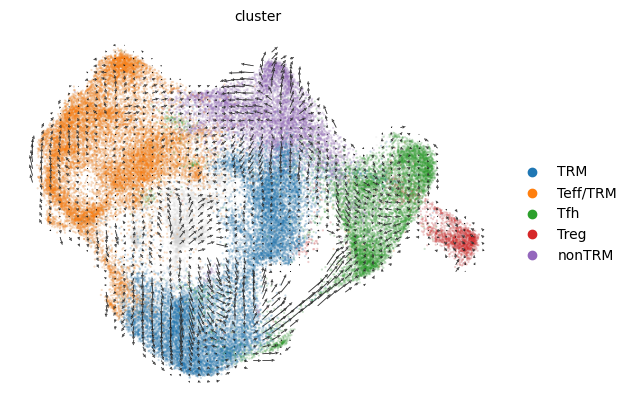

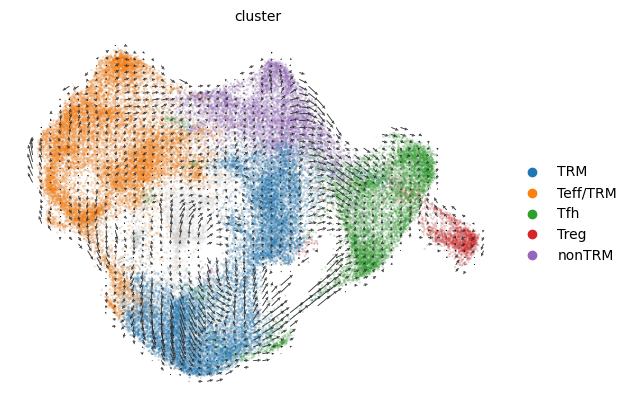

In [21]:
# embedding in UMAP
scv.pl.velocity_embedding_grid(velocyto_det, basis='umap', color="cluster", arrow_length = 2,
                               legend_loc = 'right_margin', xlabel = "UMAP 1", ylabel = "UMAP 2")

scv.pl.velocity_embedding_grid(alevin_det, basis='umap', color="cluster", arrow_length = 2,
                               legend_loc = 'right_margin', xlabel = "UMAP 1", ylabel = "UMAP 2")

#### model = stochastic

In [22]:
# calculate velocities: stochastic 
scv.tl.velocity(velocyto_sto, mode='stochastic', filter_genes=False)
scv.tl.velocity_graph(velocyto_sto)

scv.tl.velocity(alevin_sto, mode='stochastic', filter_genes=False)
scv.tl.velocity_graph(alevin_sto)

computing velocities
    finished (0:01:31) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/52 cores)
    finished (0:01:07) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocities
    finished (0:01:29) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/52 cores)
    finished (0:02:18) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:12) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


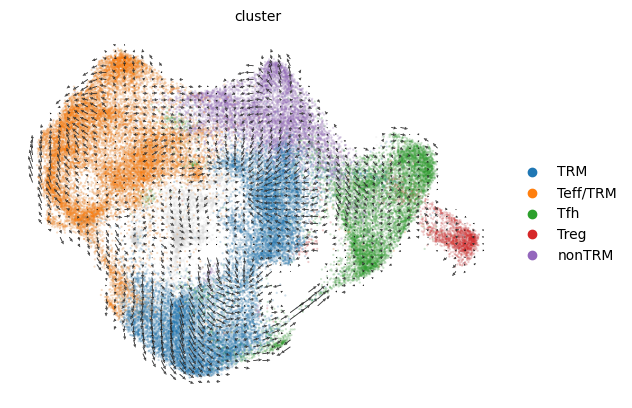

computing velocity embedding
    finished (0:00:12) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


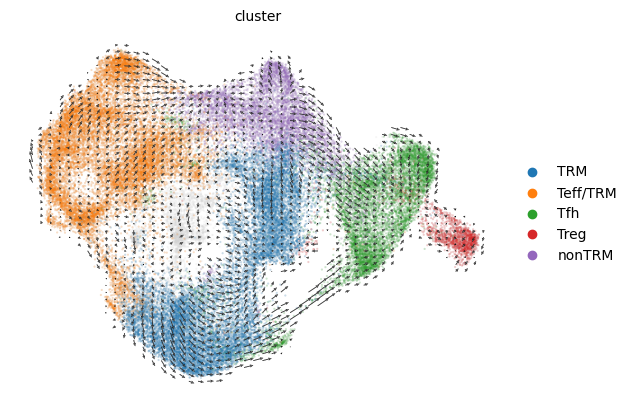

In [23]:
# embedding in UMAP
scv.pl.velocity_embedding_grid(velocyto_sto, basis='umap', color="cluster", arrow_length = 2,
                               legend_loc = 'right_margin', xlabel = "UMAP 1", ylabel = "UMAP 2")

scv.pl.velocity_embedding_grid(alevin_sto, basis='umap', color="cluster", arrow_length = 2,
                               legend_loc = 'right_margin', xlabel = "UMAP 1", ylabel = "UMAP 2")

#### model = dynamical

In [24]:
# calculate velocities: dynamical 
scv.tl.recover_dynamics(velocyto_dyn)
scv.tl.velocity(velocyto_dyn, mode="dynamical", filter_genes=False)

scv.tl.recover_dynamics(alevin_dyn)
scv.tl.velocity(alevin_dyn, mode="dynamical", filter_genes=False)

recovering dynamics (using 1/52 cores)
    finished (0:23:40) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:27) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 1/52 cores)
    finished (0:51:13) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:51) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [25]:
# velocity graph
scv.tl.velocity_graph(velocyto_dyn)

scv.tl.velocity_graph(alevin_dyn)

computing velocity graph (using 1/52 cores)
    finished (0:00:58) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph (using 1/52 cores)
    finished (0:02:20) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:14) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


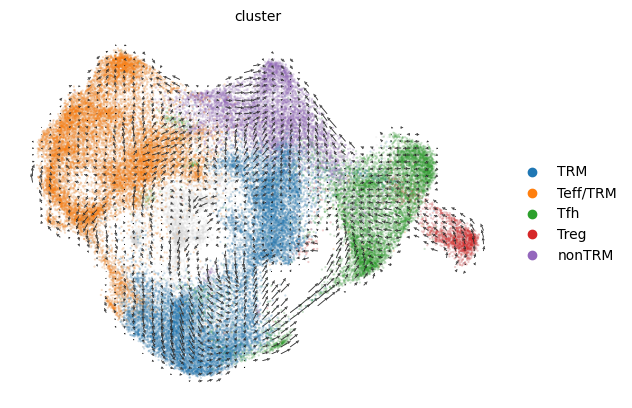

computing velocity embedding
    finished (0:00:15) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


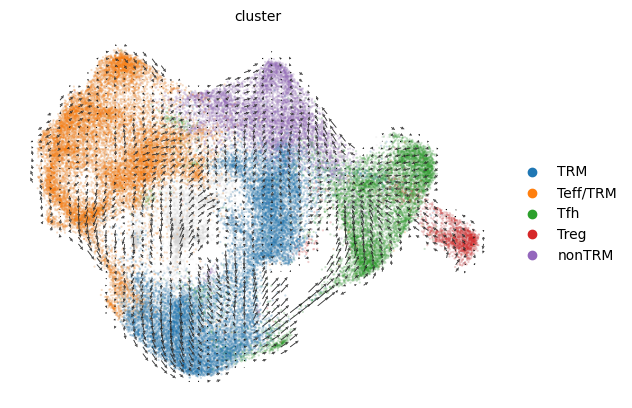

In [26]:
# embedding in UMAP
scv.pl.velocity_embedding_grid(velocyto_dyn, basis='umap', color="cluster", arrow_length = 2,
                               legend_loc = 'right_margin', xlabel = "UMAP 1", ylabel = "UMAP 2")

scv.pl.velocity_embedding_grid(alevin_dyn, basis='umap', color="cluster", arrow_length = 2,
                               legend_loc = 'right_margin', xlabel = "UMAP 1", ylabel = "UMAP 2")

### save

In [27]:
velocyto_sto.write_h5ad(filename="../data/fu_velocyto_sto.h5ad")
alevin_sto.write_h5ad(filename="../data/fu_alevin_sto.h5ad")